# Building an Agent to Play Atari games using Deep Q Network

First we import all the necessary libraries </font> 


In [1]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

Now we define a function called preprocess_observation for preprocessing our input game screen. We reduce the image size
and convert the image into greyscale.

In [15]:
color

149.33333333333334

In [43]:
color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)


 Let us initialize our gym environment

In [53]:
env.env.get_action_meanings()


['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [44]:
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n

[2019-03-25 12:20:12,648] Making new env: MsPacman-v0
/home/b/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [45]:
env.reset();

In [46]:
obs, reward, done, _ = env.step(2)

In [47]:
np.squeeze(preprocess_observation(obs)).shape

(88, 80)

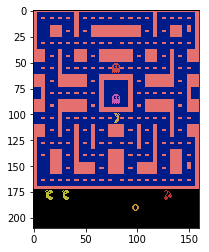

In [48]:
plt.imshow(obs)

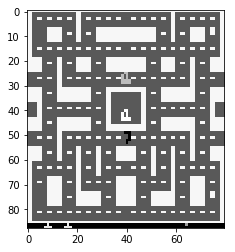

In [49]:
import matplotlib.pyplot as plt
plt.imshow(np.squeeze(preprocess_observation(obs)), cmap='gray')

In [50]:
env.close()

Okay, Now we define a function called q_network for building our Q network. We input the game state
to the Q network and get the Q values for all the actions in that state. <br><br>
We build Q network with three convolutional layers with same padding followed by a fully connected layer. 

In [51]:
tf.reset_default_graph()

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.contrib.layers.variance_scaling_initializer()

    with tf.variable_scope(name_scope) as scope: 

        # initialize the convolutional layers
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)

        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.summary.histogram('fc',fc)
        
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        return vars, output

Next we define a function called epsilon_greedy for performing epsilon greedy policy. In epsilon greedy policy we either select the best action with probability 1 - epsilon or a random action with
probability epsilon.

We use decaying epsilon greedy policy where value of epsilon will be decaying over time as we don't want to explore
forever. So over time our policy will be exploiting only good actions.

In [102]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze()
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

Now, we initialize our experience replay buffer of length 20000 which holds the experience.

We store all the agent's experience i.e (state, action, rewards) in the experience replay buffer
and  we sample from this minibatch of experience for training the network.

In [79]:
buffer = deque(maxlen=3)

In [84]:
buffer.rotate()

In [82]:
buffer.append(2)

In [85]:
buffer

deque([2, 0, 1])

In [111]:
buffer_len = 20000
exp_buffer = deque(maxlen=buffer_len)

Next, we define a function called sample_memories for sampling experiences from the memory. Batch size is the number of experience sampled
from the memory.


In [86]:
np.random.permutation(4)

array([3, 0, 2, 1])

In [90]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

Now we define our network hyperparameters,

In [114]:
num_episodes = 800
batch_size = 48
input_shape = (None, 88, 80, 1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [115]:
logdir = 'logs2'
tf.reset_default_graph()

# Now we define the placeholder for our input i.e game state
X = tf.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.placeholder(tf.bool)

 Now let us build our primary and target Q network

In [116]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')

In [117]:
# define the placeholder for our action values
X_action = tf.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)


Copy the primary Q network parameters to the target  Q network

In [118]:
copy_op = [tf.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

Compute and optimize loss using gradient descent optimizer

In [119]:
# define a placeholder for our output i.e action
y = tf.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

loss_summary = tf.summary.scalar('LOSS', loss)
merge_summary = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

 Now we start the tensorflow session and run the model,

In [120]:
with tf.Session() as sess:
    init.run()
    
    # for each episode
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # reward
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # now we train the network and calculate loss
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        print('Epoch', epoch, 'Reward', episodic_reward,)
    

Epoch 736 Reward 220.0
Epoch 806 Reward 290.0
Epoch 519 Reward 250.0
Epoch 643 Reward 250.0
Epoch 551 Reward 220.0
Epoch 599 Reward 230.0
Epoch 661 Reward 240.0
Epoch 608 Reward 190.0
Epoch 719 Reward 250.0
Epoch 615 Reward 190.0


In [122]:
Epoch 333 Reward 70.0
Epoch 882 Reward 240.0
Epoch 1145 Reward 400.0
Epoch 527 Reward 150.0
Epoch 454 Reward 160.0
Epoch 592 Reward 220.0
Epoch 778 Reward 220.0
Epoch 641 Reward 180.0
Epoch 717 Reward 260.0
Epoch 711 Reward 310.0
Epoch 667 Reward 210.0
Epoch 761 Reward 250.0
Epoch 651 Reward 180.0
Epoch 588 Reward 160.0
Epoch 728 Reward 310.0
Epoch 669 Reward 270.0
Epoch 746 Reward 220.0
Epoch 640 Reward 280.0
Epoch 674 Reward 180.0
Epoch 665 Reward 230.0
Epoch 606 Reward 160.0
Epoch 546 Reward 210.0
Epoch 631 Reward 200.0
Epoch 658 Reward 200.0
Epoch 538 Reward 200.0
Epoch 927 Reward 250.0
Epoch 639 Reward 200.0
Epoch 620 Reward 260.0
Epoch 733 Reward 330.0
Epoch 542 Reward 180.0
Epoch 518 Reward 160.0
Epoch 629 Reward 210.0
Epoch 561 Reward 120.0
Epoch 624 Reward 280.0
Epoch 703 Reward 210.0
Epoch 714 Reward 250.0
Epoch 718 Reward 300.0
Epoch 606 Reward 110.0
Epoch 680 Reward 210.0
Epoch 678 Reward 220.0
Epoch 658 Reward 260.0
Epoch 613 Reward 230.0
Epoch 683 Reward 250.0
Epoch 640 Reward 240.0
Epoch 599 Reward 220.0
Epoch 548 Reward 60.0
Epoch 653 Reward 250.0
Epoch 704 Reward 240.0
Epoch 615 Reward 190.0
Epoch 595 Reward 130.0
Epoch 664 Reward 170.0
Epoch 472 Reward 170.0
Epoch 531 Reward 240.0
Epoch 648 Reward 100.0
Epoch 907 Reward 1010.0
Epoch 440 Reward 130.0
Epoch 650 Reward 260.0
Epoch 657 Reward 180.0
Epoch 633 Reward 220.0
Epoch 767 Reward 300.0
Epoch 541 Reward 180.0
Epoch 709 Reward 260.0
Epoch 1008 Reward 820.0
Epoch 568 Reward 130.0
Epoch 1133 Reward 370.0
Epoch 560 Reward 190.0
Epoch 640 Reward 190.0
Epoch 666 Reward 130.0
Epoch 746 Reward 260.0
Epoch 784 Reward 370.0
Epoch 689 Reward 300.0
Epoch 517 Reward 160.0
Epoch 817 Reward 430.0
Epoch 643 Reward 200.0
Epoch 544 Reward 110.0
Epoch 675 Reward 270.0
Epoch 671 Reward 340.0
Epoch 639 Reward 240.0
Epoch 650 Reward 300.0
Epoch 716 Reward 340.0
Epoch 662 Reward 290.0
Epoch 931 Reward 550.0
Epoch 634 Reward 220.0
Epoch 813 Reward 320.0
Epoch 640 Reward 270.0
Epoch 513 Reward 210.0
Epoch 698 Reward 290.0
Epoch 645 Reward 330.0
Epoch 727 Reward 280.0
Epoch 520 Reward 90.0
Epoch 664 Reward 260.0
Epoch 625 Reward 170.0
Epoch 663 Reward 200.0
Epoch 523 Reward 190.0
Epoch 663 Reward 280.0
Epoch 649 Reward 220.0
Epoch 973 Reward 650.0
Epoch 456 Reward 150.0
Epoch 939 Reward 380.0
Epoch 617 Reward 140.0
Epoch 812 Reward 290.0
Epoch 734 Reward 480.0
Epoch 677 Reward 300.0
Epoch 728 Reward 330.0
Epoch 522 Reward 160.0
Epoch 669 Reward 180.0
Epoch 634 Reward 190.0
Epoch 669 Reward 250.0
Epoch 629 Reward 200.0
Epoch 559 Reward 160.0
Epoch 491 Reward 150.0
Epoch 563 Reward 190.0
Epoch 659 Reward 210.0
Epoch 695 Reward 190.0
Epoch 585 Reward 240.0
Epoch 707 Reward 290.0
Epoch 647 Reward 240.0
Epoch 687 Reward 290.0
Epoch 617 Reward 170.0
Epoch 672 Reward 220.0
Epoch 666 Reward 200.0
Epoch 579 Reward 220.0
Epoch 703 Reward 310.0
Epoch 504 Reward 160.0
Epoch 1056 Reward 990.0
Epoch 551 Reward 190.0
Epoch 436 Reward 110.0
Epoch 697 Reward 260.0
Epoch 534 Reward 170.0
Epoch 508 Reward 190.0
Epoch 520 Reward 180.0
Epoch 578 Reward 200.0
Epoch 661 Reward 180.0
Epoch 653 Reward 260.0
Epoch 432 Reward 160.0
Epoch 1069 Reward 1100.0
Epoch 641 Reward 160.0
Epoch 597 Reward 70.0
Epoch 738 Reward 390.0
Epoch 619 Reward 250.0
Epoch 849 Reward 450.0
Epoch 647 Reward 310.0
Epoch 678 Reward 300.0
Epoch 750 Reward 270.0
Epoch 568 Reward 210.0
Epoch 592 Reward 260.0
Epoch 656 Reward 190.0
Epoch 617 Reward 270.0
Epoch 737 Reward 250.0
Epoch 694 Reward 180.0
Epoch 554 Reward 140.0
Epoch 548 Reward 210.0
Epoch 696 Reward 250.0
Epoch 691 Reward 220.0
Epoch 631 Reward 250.0
Epoch 580 Reward 230.0
Epoch 588 Reward 150.0
Epoch 704 Reward 250.0
Epoch 589 Reward 190.0
Epoch 565 Reward 180.0
Epoch 511 Reward 160.0
Epoch 689 Reward 220.0
Epoch 596 Reward 190.0
Epoch 606 Reward 180.0
Epoch 574 Reward 190.0
Epoch 700 Reward 450.0
Epoch 660 Reward 240.0
Epoch 569 Reward 160.0
Epoch 671 Reward 260.0
Epoch 906 Reward 500.0
Epoch 586 Reward 200.0
Epoch 693 Reward 250.0
Epoch 666 Reward 300.0
Epoch 763 Reward 390.0
Epoch 710 Reward 230.0
Epoch 621 Reward 260.0
Epoch 556 Reward 260.0
Epoch 674 Reward 160.0
Epoch 505 Reward 110.0
Epoch 553 Reward 150.0
Epoch 635 Reward 240.0
Epoch 617 Reward 260.0
Epoch 842 Reward 310.0
Epoch 674 Reward 250.0
Epoch 685 Reward 270.0
Epoch 717 Reward 320.0
Epoch 670 Reward 300.0
Epoch 489 Reward 200.0
Epoch 711 Reward 310.0
Epoch 584 Reward 200.0
Epoch 607 Reward 230.0
Epoch 704 Reward 250.0
Epoch 754 Reward 270.0
Epoch 641 Reward 240.0
Epoch 808 Reward 360.0
Epoch 619 Reward 210.0
Epoch 649 Reward 200.0
Epoch 1030 Reward 780.0
Epoch 820 Reward 320.0
Epoch 615 Reward 250.0
Epoch 585 Reward 210.0
Epoch 1224 Reward 1380.0
Epoch 703 Reward 250.0
Epoch 823 Reward 760.0
Epoch 713 Reward 350.0
Epoch 912 Reward 470.0
Epoch 639 Reward 250.0
Epoch 717 Reward 240.0
Epoch 673 Reward 290.0
Epoch 435 Reward 150.0
Epoch 572 Reward 250.0
Epoch 645 Reward 290.0
Epoch 675 Reward 230.0
Epoch 540 Reward 190.0
Epoch 554 Reward 240.0
Epoch 782 Reward 410.0
Epoch 477 Reward 170.0
Epoch 576 Reward 220.0
Epoch 1213 Reward 440.0
Epoch 651 Reward 230.0
Epoch 737 Reward 350.0
Epoch 565 Reward 270.0
Epoch 706 Reward 320.0
Epoch 784 Reward 350.0
Epoch 1052 Reward 460.0
Epoch 528 Reward 240.0
Epoch 732 Reward 290.0
Epoch 459 Reward 130.0
Epoch 646 Reward 250.0
Epoch 791 Reward 490.0
Epoch 801 Reward 450.0
Epoch 517 Reward 180.0
Epoch 954 Reward 800.0
Epoch 700 Reward 240.0
Epoch 744 Reward 200.0
Epoch 513 Reward 180.0
Epoch 656 Reward 270.0
Epoch 651 Reward 410.0
Epoch 696 Reward 320.0
Epoch 767 Reward 250.0
Epoch 878 Reward 350.0
Epoch 450 Reward 250.0
Epoch 787 Reward 300.0
Epoch 576 Reward 210.0
Epoch 1520 Reward 720.0
Epoch 623 Reward 170.0
Epoch 562 Reward 190.0
Epoch 626 Reward 330.0
Epoch 574 Reward 270.0
Epoch 685 Reward 300.0
Epoch 561 Reward 150.0
Epoch 527 Reward 250.0
Epoch 684 Reward 220.0
Epoch 960 Reward 1730.0
Epoch 598 Reward 350.0
Epoch 735 Reward 250.0
Epoch 513 Reward 180.0
Epoch 656 Reward 430.0
Epoch 752 Reward 300.0
Epoch 534 Reward 240.0
Epoch 568 Reward 240.0
Epoch 800 Reward 390.0
Epoch 628 Reward 170.0
Epoch 710 Reward 350.0
Epoch 505 Reward 170.0
Epoch 689 Reward 270.0
Epoch 580 Reward 270.0
Epoch 597 Reward 160.0
Epoch 635 Reward 270.0
Epoch 920 Reward 550.0
Epoch 770 Reward 350.0
Epoch 880 Reward 1050.0
Epoch 648 Reward 210.0
Epoch 859 Reward 720.0
Epoch 705 Reward 220.0
Epoch 1095 Reward 490.0
Epoch 679 Reward 370.0
Epoch 649 Reward 330.0
Epoch 616 Reward 540.0
Epoch 517 Reward 170.0
Epoch 934 Reward 500.0
Epoch 845 Reward 450.0
Epoch 1651 Reward 1020.0
Epoch 825 Reward 410.0
Epoch 684 Reward 270.0
Epoch 937 Reward 560.0
Epoch 547 Reward 240.0
Epoch 718 Reward 360.0
Epoch 981 Reward 400.0
Epoch 835 Reward 560.0
Epoch 779 Reward 550.0
Epoch 776 Reward 700.0
Epoch 815 Reward 600.0
Epoch 613 Reward 230.0
Epoch 787 Reward 310.0
Epoch 591 Reward 140.0
Epoch 503 Reward 160.0
Epoch 699 Reward 380.0
Epoch 1121 Reward 600.0
Epoch 635 Reward 330.0
Epoch 524 Reward 210.0
Epoch 686 Reward 310.0
Epoch 747 Reward 600.0
Epoch 1212 Reward 860.0
Epoch 595 Reward 190.0
Epoch 371 Reward 90.0
Epoch 540 Reward 190.0
Epoch 640 Reward 320.0
Epoch 733 Reward 420.0
Epoch 547 Reward 240.0
Epoch 659 Reward 380.0
Epoch 740 Reward 380.0
Epoch 824 Reward 420.0
Epoch 657 Reward 220.0
Epoch 732 Reward 310.0
Epoch 626 Reward 340.0
Epoch 577 Reward 260.0
Epoch 694 Reward 360.0
Epoch 771 Reward 420.0
Epoch 906 Reward 590.0
Epoch 475 Reward 230.0
Epoch 1158 Reward 1500.0
Epoch 885 Reward 600.0
Epoch 585 Reward 330.0
Epoch 532 Reward 220.0
Epoch 775 Reward 570.0
Epoch 492 Reward 190.0
Epoch 519 Reward 260.0
Epoch 855 Reward 580.0
Epoch 758 Reward 450.0
Epoch 760 Reward 390.0
Epoch 613 Reward 250.0
Epoch 687 Reward 340.0
Epoch 529 Reward 180.0
Epoch 582 Reward 270.0
Epoch 852 Reward 420.0
Epoch 1436 Reward 1140.0
Epoch 1390 Reward 1220.0
Epoch 637 Reward 390.0
Epoch 461 Reward 170.0
Epoch 590 Reward 210.0
Epoch 782 Reward 450.0
Epoch 491 Reward 170.0
Epoch 637 Reward 280.0
Epoch 698 Reward 370.0
Epoch 728 Reward 600.0
Epoch 662 Reward 350.0
Epoch 744 Reward 530.0
Epoch 798 Reward 750.0
Epoch 624 Reward 300.0
Epoch 660 Reward 340.0
Epoch 635 Reward 370.0
Epoch 576 Reward 280.0
Epoch 640 Reward 370.0
Epoch 529 Reward 250.0
Epoch 742 Reward 260.0
Epoch 728 Reward 470.0
Epoch 656 Reward 320.0
Epoch 682 Reward 550.0
Epoch 610 Reward 380.0
Epoch 1097 Reward 810.0
Epoch 813 Reward 480.0
Epoch 742 Reward 410.0
Epoch 727 Reward 390.0
Epoch 653 Reward 420.0
Epoch 594 Reward 290.0
Epoch 620 Reward 340.0
Epoch 630 Reward 270.0
Epoch 866 Reward 500.0
Epoch 582 Reward 240.0
Epoch 863 Reward 390.0
Epoch 899 Reward 690.0
Epoch 795 Reward 680.0
Epoch 503 Reward 220.0
Epoch 1013 Reward 1020.0
Epoch 596 Reward 350.0
Epoch 727 Reward 500.0
Epoch 596 Reward 270.0
Epoch 619 Reward 370.0
Epoch 815 Reward 340.0
Epoch 607 Reward 290.0
Epoch 585 Reward 390.0
Epoch 539 Reward 250.0
Epoch 712 Reward 440.0
Epoch 481 Reward 170.0
Epoch 619 Reward 250.0
Epoch 674 Reward 420.0
Epoch 643 Reward 400.0
Epoch 837 Reward 660.0
Epoch 1433 Reward 1480.0
Epoch 694 Reward 380.0
Epoch 550 Reward 290.0
Epoch 848 Reward 400.0
Epoch 826 Reward 750.0
Epoch 682 Reward 570.0
Epoch 934 Reward 890.0
Epoch 706 Reward 570.0
Epoch 908 Reward 700.0
Epoch 1283 Reward 860.0
Epoch 886 Reward 600.0
Epoch 832 Reward 520.0
Epoch 484 Reward 260.0
Epoch 1112 Reward 920.0
Epoch 665 Reward 300.0
Epoch 817 Reward 1190.0
Epoch 1045 Reward 770.0
Epoch 833 Reward 540.0
Epoch 494 Reward 330.0
Epoch 557 Reward 270.0
Epoch 555 Reward 220.0
Epoch 864 Reward 1200.0
Epoch 923 Reward 780.0
Epoch 542 Reward 270.0
Epoch 501 Reward 190.0
Epoch 1208 Reward 1610.0
Epoch 818 Reward 690.0
Epoch 1086 Reward 1830.0
Epoch 720 Reward 350.0
Epoch 604 Reward 440.0
Epoch 497 Reward 290.0
Epoch 752 Reward 300.0
Epoch 687 Reward 400.0
Epoch 917 Reward 870.0
Epoch 1086 Reward 960.0
Epoch 918 Reward 670.0
Epoch 1049 Reward 740.0
Epoch 978 Reward 690.0
Epoch 494 Reward 260.0
Epoch 702 Reward 630.0
Epoch 834 Reward 530.0
Epoch 632 Reward 360.0
Epoch 777 Reward 690.0
Epoch 671 Reward 570.0
Epoch 889 Reward 690.0
Epoch 807 Reward 590.0
Epoch 466 Reward 260.0
Epoch 983 Reward 540.0
Epoch 548 Reward 250.0
Epoch 509 Reward 200.0
Epoch 506 Reward 290.0
Epoch 650 Reward 400.0
Epoch 918 Reward 700.0
Epoch 821 Reward 460.0
Epoch 702 Reward 350.0
Epoch 595 Reward 430.0
Epoch 750 Reward 530.0
Epoch 896 Reward 340.0
Epoch 1265 Reward 1010.0
Epoch 760 Reward 520.0
Epoch 570 Reward 250.0
Epoch 555 Reward 230.0
Epoch 685 Reward 420.0
Epoch 581 Reward 390.0
Epoch 780 Reward 480.0
Epoch 836 Reward 880.0
Epoch 503 Reward 310.0
Epoch 720 Reward 610.0
Epoch 483 Reward 300.0
Epoch 732 Reward 370.0
Epoch 972 Reward 1020.0
Epoch 563 Reward 190.0
Epoch 438 Reward 160.0
Epoch 435 Reward 160.0
Epoch 707 Reward 420.0
Epoch 542 Reward 170.0
Epoch 453 Reward 230.0
Epoch 684 Reward 730.0
Epoch 924 Reward 720.0
Epoch 835 Reward 450.0
Epoch 828 Reward 430.0
Epoch 820 Reward 660.0
Epoch 1089 Reward 1040.0
Epoch 698 Reward 580.0
Epoch 324 Reward 70.0
Epoch 968 Reward 940.0
Epoch 480 Reward 240.0
Epoch 625 Reward 270.0
Epoch 786 Reward 570.0
Epoch 471 Reward 240.0
Epoch 1117 Reward 1200.0
Epoch 464 Reward 290.0
Epoch 713 Reward 270.0
Epoch 712 Reward 360.0
Epoch 639 Reward 440.0
Epoch 768 Reward 490.0
Epoch 547 Reward 270.0
Epoch 944 Reward 610.0
Epoch 1070 Reward 1970.0
Epoch 1116 Reward 1140.0
Epoch 661 Reward 210.0
Epoch 529 Reward 260.0
Epoch 597 Reward 400.0
Epoch 512 Reward 260.0
Epoch 672 Reward 410.0
Epoch 681 Reward 350.0
Epoch 554 Reward 260.0
Epoch 1231 Reward 890.0
Epoch 627 Reward 310.0
Epoch 711 Reward 450.0
Epoch 509 Reward 330.0
Epoch 861 Reward 360.0
Epoch 835 Reward 590.0
Epoch 677 Reward 1900.0
Epoch 867 Reward 640.0
Epoch 922 Reward 520.0
Epoch 666 Reward 300.0
Epoch 903 Reward 490.0
Epoch 742 Reward 450.0
Epoch 658 Reward 410.0
Epoch 976 Reward 510.0
Epoch 874 Reward 790.0
Epoch 508 Reward 240.0
Epoch 850 Reward 960.0
Epoch 962 Reward 1150.0
Epoch 752 Reward 280.0
Epoch 1199 Reward 1120.0
Epoch 472 Reward 270.0
Epoch 619 Reward 400.0
Epoch 502 Reward 350.0
Epoch 670 Reward 380.0
Epoch 643 Reward 510.0
Epoch 780 Reward 420.0
Epoch 523 Reward 160.0
Epoch 882 Reward 540.0
Epoch 1420 Reward 770.0
Epoch 649 Reward 430.0
Epoch 515 Reward 410.0
Epoch 572 Reward 220.0
Epoch 993 Reward 1140.0
Epoch 649 Reward 500.0
Epoch 777 Reward 500.0
Epoch 882 Reward 310.0
Epoch 482 Reward 220.0
Epoch 469 Reward 280.0
Epoch 798 Reward 470.0
Epoch 780 Reward 320.0
Epoch 613 Reward 470.0
Epoch 447 Reward 110.0
Epoch 797 Reward 600.0
Epoch 590 Reward 270.0
Epoch 1011 Reward 1380.0
Epoch 919 Reward 700.0
Epoch 1026 Reward 970.0
Epoch 667 Reward 430.0
Epoch 832 Reward 630.0
Epoch 623 Reward 480.0
Epoch 1073 Reward 860.0
Epoch 521 Reward 430.0
Epoch 1097 Reward 920.0
Epoch 607 Reward 260.0
Epoch 636 Reward 260.0
Epoch 850 Reward 560.0
Epoch 487 Reward 280.0
Epoch 751 Reward 590.0
Epoch 844 Reward 1180.0
Epoch 663 Reward 440.0
Epoch 964 Reward 780.0
Epoch 858 Reward 750.0
Epoch 535 Reward 330.0
Epoch 572 Reward 300.0
Epoch 857 Reward 1170.0
Epoch 1240 Reward 870.0
Epoch 777 Reward 550.0
Epoch 906 Reward 800.0
Epoch 1148 Reward 1470.0
Epoch 953 Reward 500.0
Epoch 574 Reward 360.0
Epoch 693 Reward 350.0
Epoch 682 Reward 520.0
Epoch 525 Reward 320.0
Epoch 638 Reward 530.0
Epoch 1427 Reward 2420.0
Epoch 909 Reward 880.0
Epoch 1173 Reward 1300.0
Epoch 631 Reward 510.0
Epoch 411 Reward 250.0
Epoch 843 Reward 410.0
Epoch 1516 Reward 790.0
Epoch 790 Reward 590.0
Epoch 577 Reward 250.0
Epoch 470 Reward 290.0
Epoch 1014 Reward 930.0
Epoch 554 Reward 330.0
Epoch 916 Reward 1210.0
Epoch 531 Reward 360.0
Epoch 1203 Reward 770.0
Epoch 571 Reward 250.0
Epoch 1172 Reward 710.0
Epoch 487 Reward 310.0
Epoch 754 Reward 520.0
Epoch 1178 Reward 1920.0
Epoch 689 Reward 610.0
Epoch 419 Reward 230.0
Epoch 682 Reward 410.0
Epoch 646 Reward 360.0
Epoch 707 Reward 320.0
Epoch 546 Reward 360.0
Epoch 491 Reward 420.0
Epoch 758 Reward 520.0
Epoch 771 Reward 600.0
Epoch 787 Reward 530.0
Epoch 683 Reward 440.0
Epoch 711 Reward 610.0
Epoch 587 Reward 310.0
Epoch 1082 Reward 660.0
Epoch 517 Reward 290.0
Epoch 435 Reward 210.0
Epoch 689 Reward 570.0
Epoch 839 Reward 440.0
Epoch 800 Reward 960.0
Epoch 455 Reward 190.0
Epoch 845 Reward 510.0
Epoch 703 Reward 960.0
Epoch 958 Reward 1080.0
Epoch 463 Reward 180.0
Epoch 559 Reward 350.0
Epoch 486 Reward 320.0
Epoch 1103 Reward 860.0
Epoch 718 Reward 360.0
Epoch 1117 Reward 1170.0
Epoch 654 Reward 330.0
Epoch 939 Reward 490.0
Epoch 710 Reward 240.0
Epoch 835 Reward 890.0
Epoch 868 Reward 690.0
Epoch 579 Reward 220.0
Epoch 580 Reward 330.0
Epoch 410 Reward 70.0
Epoch 500 Reward 270.0
Epoch 993 Reward 590.0
Epoch 1159 Reward 580.0
Epoch 582 Reward 370.0
Epoch 361 Reward 110.0
Epoch 703 Reward 430.0
Epoch 920 Reward 1300.0
Epoch 867 Reward 1210.0
Epoch 572 Reward 320.0
Epoch 1129 Reward 1550.0
Epoch 712 Reward 250.0
Epoch 579 Reward 460.0
Epoch 796 Reward 450.0
Epoch 980 Reward 460.0
Epoch 1047 Reward 1300.0
Epoch 911 Reward 500.0
Epoch 617 Reward 510.0
Epoch 649 Reward 560.0
Epoch 547 Reward 370.0
Epoch 867 Reward 750.0
Epoch 1449 Reward 1540.0
Epoch 967 Reward 510.0
Epoch 792 Reward 420.0
Epoch 786 Reward 610.0
Epoch 606 Reward 440.0
Epoch 742 Reward 590.0
Epoch 472 Reward 150.0
Epoch 814 Reward 720.0
Epoch 795 Reward 1130.0
Epoch 1357 Reward 1520.0
Epoch 624 Reward 370.0
Epoch 841 Reward 1070.0
Epoch 520 Reward 360.0
Epoch 662 Reward 480.0
Epoch 673 Reward 380.0
Epoch 527 Reward 230.0
Epoch 749 Reward 330.0
Epoch 1337 Reward 1460.0
Epoch 1012 Reward 680.0
Epoch 730 Reward 440.0
Epoch 724 Reward 530.0
Epoch 989 Reward 2070.0
Epoch 880 Reward 560.0
Epoch 697 Reward 350.0
Epoch 507 Reward 240.0
Epoch 954 Reward 720.0
Epoch 652 Reward 430.0
Epoch 747 Reward 570.0

SyntaxError: invalid syntax (<ipython-input-122-10eb25ca27f4>, line 1)